# PV from pvlib

https://pvlib-python.readthedocs.io/en/stable/user_guide/introtutorial.html

In [24]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import pvlib
from pvlib.location import Location
from pvlib.modelchain import ModelChain
from pvlib.pvsystem import Array, FixedMount, PVSystem

### Location

In [2]:
# Vienna coordinates
latitude = 48.208
longitude = 16.3738
altitude = 172
tz = "Europe/Vienna"

In [3]:
tilt = 30
azimuth = 180

In [4]:
Location

pvlib.location.Location

### Module Parameters

In [5]:
# Module parameters
sandia_modules = pvlib.pvsystem.retrieve_sam("SandiaMod")
sapm_inverters = pvlib.pvsystem.retrieve_sam("cecinverter")
print(
    f"{len(sandia_modules.columns)} Modules, {len(sapm_inverters.columns)} Inverters."
)
print(sandia_modules.columns[range(10, 520, 100)])
print(sapm_inverters.columns[range(10, 3300, 1000)])

523 Modules, 3264 Inverters.
Index(['AstroPower_AP_100___2001_', 'BP_Solar_SX60__2003__E__',
       'Photowatt_PW6_110__2003__E__', 'Sharp_NE_H120E1___2001_',
       'Siemens_Solar_SR90__12V____1998_',
       'Yingli_Solar_YL230_29b_Module___2009_'],
      dtype='object')
Index(['ABB__PVI_3_0_OUTD_S_US__240V_',
       'Eoplly_New_Energy_Technology__EP156MB_60_230S_AC__240V_',
       'Power_Electronics__FS2110CU__420V_',
       'Sunna_Tech__SUNNA_3000TL_US_240__240V_'],
      dtype='object')


In [6]:
module = sandia_modules["Canadian_Solar_CS5P_220M___2009_"]
module.head()

Vintage              2009
Area                1.701
Material             c-Si
Cells_in_Series        96
Parallel_Strings        1
Name: Canadian_Solar_CS5P_220M___2009_, dtype: object

In [7]:
inverter = sapm_inverters["ABB__PVI_10_0_I_OUTD_x_US_208_y__208V_"]
inverter.head()

Vac              208
Pso        46.863808
Paco         10000.0
Pdco    10488.306641
Vdco           320.0
Name: ABB__PVI_10_0_I_OUTD_x_US_208_y__208V_, dtype: object

In [8]:
temperature_models = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS["sapm"]
print(temperature_models.keys())
temperature_model_parameters = temperature_models["open_rack_glass_glass"]
temperature_model_parameters

dict_keys(['open_rack_glass_glass', 'close_mount_glass_glass', 'open_rack_glass_polymer', 'insulated_back_glass_polymer'])


{'a': -3.47, 'b': -0.0594, 'deltaT': 3}

### Weather

In [9]:
# Get weather for a measured year between 2005 and 2016,
# should alrady parse tilt and azimuth here, returns POA irradiance.
year_weather = pvlib.iotools.get_pvgis_hourly(
    latitude, longitude, start=2015, end=2015
)[0]

In [10]:
# Get measured data for a typical year from the same dataset
# this returns components ghi, dni, dhi
tmy_weather = pvlib.iotools.get_pvgis_tmy(latitude, longitude)[
    0
]  # Typical meteorolgical year

In [11]:
tmy_weather.index = pd.to_datetime("2015-" + tmy_weather.index.strftime("%m-%dT%H%M"))

<Axes: xlabel='time(UTC)'>

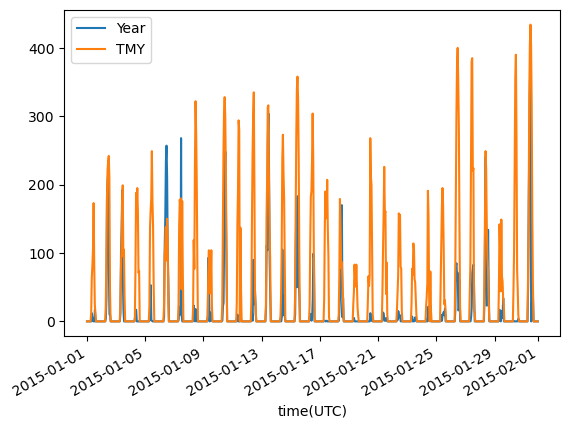

In [12]:
ax = year_weather["poa_direct"]["2015-01"].plot(label="Year", legend=True)
tmy_weather["ghi"]["2015-01"].plot(ax=ax, label="TMY", legend=True)

## Calculation

We are using the Object Oriented approach, as it is a bit more clear in my opinion.

In [13]:
location = Location(
    latitude,
    longitude,
    name="Vienna",
    altitude=altitude,
    tz=tz,
)

In [14]:
mount = FixedMount(surface_tilt=tilt, surface_azimuth=azimuth)
array = Array(
    mount=mount,
    module_parameters=module,
    temperature_model_parameters=temperature_model_parameters,
    modules_per_string=8,
)
system = PVSystem(arrays=[array], inverter_parameters=inverter)

In [15]:
mc = ModelChain(system, location)
mc

ModelChain: 
  name: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: sapm
  ac_model: sandia_inverter
  aoi_model: sapm_aoi_loss
  spectral_model: sapm_spectral_loss
  temperature_model: sapm_temp
  losses_model: no_extra_losses

In [16]:
mc.run_model(tmy_weather)
# mc.run_model_from_poa(year_weather) # For yearly data would have to convert to needed parameters

ModelChain: 
  name: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: sapm
  ac_model: sandia_inverter
  aoi_model: sapm_aoi_loss
  spectral_model: sapm_spectral_loss
  temperature_model: sapm_temp
  losses_model: no_extra_losses

In [17]:
annual_energy = mc.results.ac.sum()
annual_energy

np.float64(2213586.8369852635)

In [18]:
pv_gen_ts = mc.results.ac
pv_gen_ts.sample(5)

time(UTC)
2015-07-10 16:00:00      -0.100000
2015-10-05 19:00:00      -0.100000
2015-09-28 06:00:00       1.610547
2015-06-10 14:00:00    1019.482016
2015-09-28 23:00:00      -0.100000
dtype: float64

<Axes: xlabel='time(UTC)'>

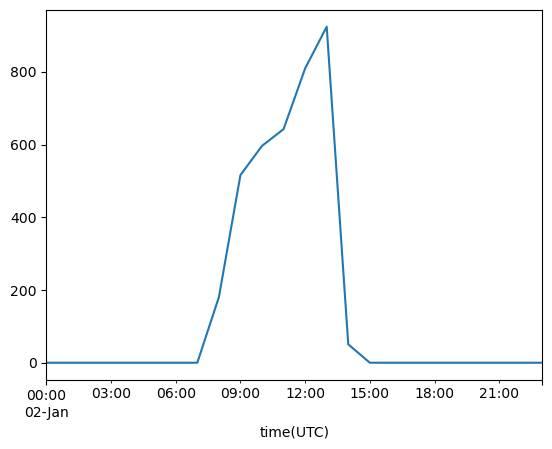

In [19]:
pv_gen_ts["2015-01-02"].plot()

<Axes: xlabel='time(UTC)'>

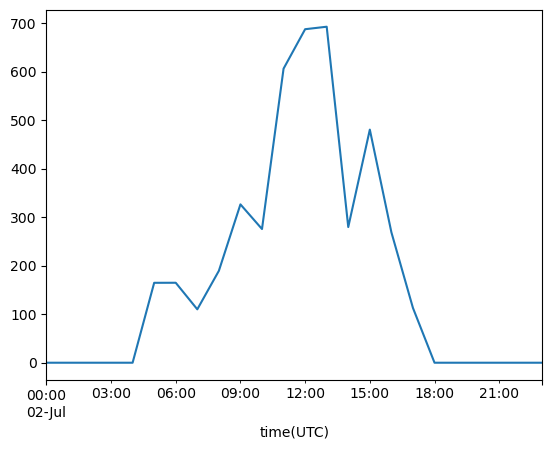

In [20]:
pv_gen_ts["2015-07-02"].plot()

### Save results to file

In [26]:
os.makedirs("outputs", exist_ok=True)
pv_gen_ts.to_csv("outputs/pv_example.csv")